# Pipeline for High-z Radio Galaxies 09: SHAP values for meta models in prediction

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the meta-learners used for predictions.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
from sklearn.model_selection import train_test_split
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import shap
import fasttreeshap
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

---

In [4]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False
use_calibration     = True
use_high_z_sources  = True
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies)

### Load data

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [5]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Test_Train'  # Validation, Training, Test, Test_Train
if not use_high_z_sources:
    if used_area == 'HETDEX':
        subset_str = f'_{HETDEX_subset}'
    if used_area != 'HETDEX':
        subset_str = ''
elif use_high_z_sources:
    subset_str     = ''

In [6]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [7]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect', ]
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [8]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [9]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [10]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [11]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

#### Select relevant sources

In [12]:
if use_high_z_sources:  # Only use high-z AGN
    # filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= gv.high_z_limit)
    filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= 4.0) & np.array(full_catalog_df.loc[:, 'class'] == 1)
    full_catalog_df    = full_catalog_df.loc[filter_selection]
    high_z_str         = '_high_z'
if not use_high_z_sources:
    high_z_str         = ''

In [13]:
if not use_high_z_sources:
    if used_area == 'HETDEX':
        if use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
        elif not use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
        unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
        full_catalog_df   = full_catalog_df.loc[filter_known_spec]
        train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
        print('Shape of used data in HETDEX')
        print('-' * 65)
        print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
        print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
        print(f'Training data:                                    {train_df.shape}')
        print(f'Testing data:                                     {test_df.shape}')
        if use_calibration:
            print(f'Calibration data:                                 {calibration_df.shape}')
        print(f'Validation data:                                  {validation_df.shape}')
        print('-' * 65)
        print()
        print(f'Using {HETDEX_subset} data from HETDEX')
        selected_dataset = {'Training': train_df, 'Test': test_df, 'Test_Train': train_test_df,\
                            'Validation': validation_df, 'Calibration': calibration_df}
        full_catalog_df = selected_dataset[HETDEX_subset]

In [14]:
if not use_high_z_sources:
    if used_area != 'HETDEX':
        filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                           (full_catalog_df.loc[:, 'class'] == 1) |\
                           (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
        unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
        full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [15]:
full_catalog_df          = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp'])

In [16]:
if not use_high_z_sources:
    if use_unknown:
        full_catalog_df = unknown_cat_df
    filter_selection   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

In [17]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')
print(f'From them, {np.sum(full_catalog_df.loc[:, "class"] == 1)} are confirmed AGN.')
print(f'From all the sources, {np.sum(full_catalog_df.loc[:, "LOFAR_detect"] == 1)} have radio (LOFAR-like) detection.')
print(f'From the {np.sum(full_catalog_df.loc[:, "class"] == 1)} AGN,\
 {np.sum((full_catalog_df.loc[:, "class"] == 1) & (full_catalog_df.loc[:, "LOFAR_detect"] == 1))} have radio (LOFAR-like) detection.')

Full used dataset size:              (121, 90)
--------------------------------------------------
Thus, it has 121 sources and 90 features.
From them, 121 are confirmed AGN.
From all the sources, 29 have radio (LOFAR-like) detection.
From the 121 AGN, 29 have radio (LOFAR-like) detection.


### Load models

In [18]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # sources with predicted z >= 3.6

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [19]:
if use_zeroth_model:
    threshold_star_logit = np.log(gv.star_thresh  / (1 - gv.star_thresh))
threshold_AGN_logit      = np.log(gv.AGN_thresh   / (1 - gv.AGN_thresh))
threshold_radio_logit    = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

#### Predictions

In [20]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=gv.star_thresh, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [21]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [22]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [23]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [24]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [25]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

## Use SHAP

Flags to run on each meta learner.

In [26]:
run_shap_AGN_meta    = True
run_shap_radio_meta  = True
run_shap_z_meta      = True
run_shap_high_z_meta = True

In [27]:
if use_zeroth_model:
    filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### SHAP - AGN/galaxy model

In [28]:
if run_shap_AGN_meta:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [29]:
if run_shap_AGN_meta:
    base_sample_size_AGN = 1000
    sample_size_AGN = np.nanmin([np.sum(filter_pred_no_str), base_sample_size_AGN])
    print(f'Number of selected elements: {sample_size_AGN:,}')

Number of selected elements: 121


In [30]:
if run_shap_AGN_meta:
    base_models_names_AGN = gf.get_base_estimators_names(AGN_gal_clf)

In [31]:
if run_shap_AGN_meta:
    reduced_data_AGN    = full_catalog_df.loc[filter_pred_no_str].sample(n=sample_size_AGN, random_state=gv.seed).copy()
    display(reduced_data_AGN.loc[:, ['class', 'pred_class']].describe())
    reduced_data_AGN_df = gf.preprocess_data(AGN_gal_clf, reduced_data_AGN, base_models_names_AGN)
    reduced_cols_AGN    = reduced_data_AGN_df.columns

,class,pred_class
count,121.0,121.000000
mean,1.0,0.859504
std,0.0,0.348946
min,1.0,0.000000
25%,1.0,1.000000
50%,1.0,1.000000
75%,1.0,1.000000
max,1.0,1.000000


Use FastTreeSHAP package

In [32]:
if run_shap_AGN_meta:
    explainer_AGN_meta = fasttreeshap.TreeExplainer(AGN_gal_clf.named_steps['trained_model'].final_estimator_,\
                                                    data=None, feature_perturbation='tree_path_dependent',\
                                                    model_output='raw', feature_dependence='independent',\
                                                    algorithm='auto', n_jobs=12)

In [33]:
if run_shap_AGN_meta:
    print('Working with meta-model')
    shap_values_AGN_meta = explainer_AGN_meta(reduced_data_AGN_df, check_additivity=False)

Working with meta-model


In [34]:
if run_shap_AGN_meta:
    print(explainer_AGN_meta.expected_value)
    print(np.exp(explainer_AGN_meta.expected_value) / (1 + np.exp(explainer_AGN_meta.expected_value)))

-7.87261029228056e-05
0.49998031847427943


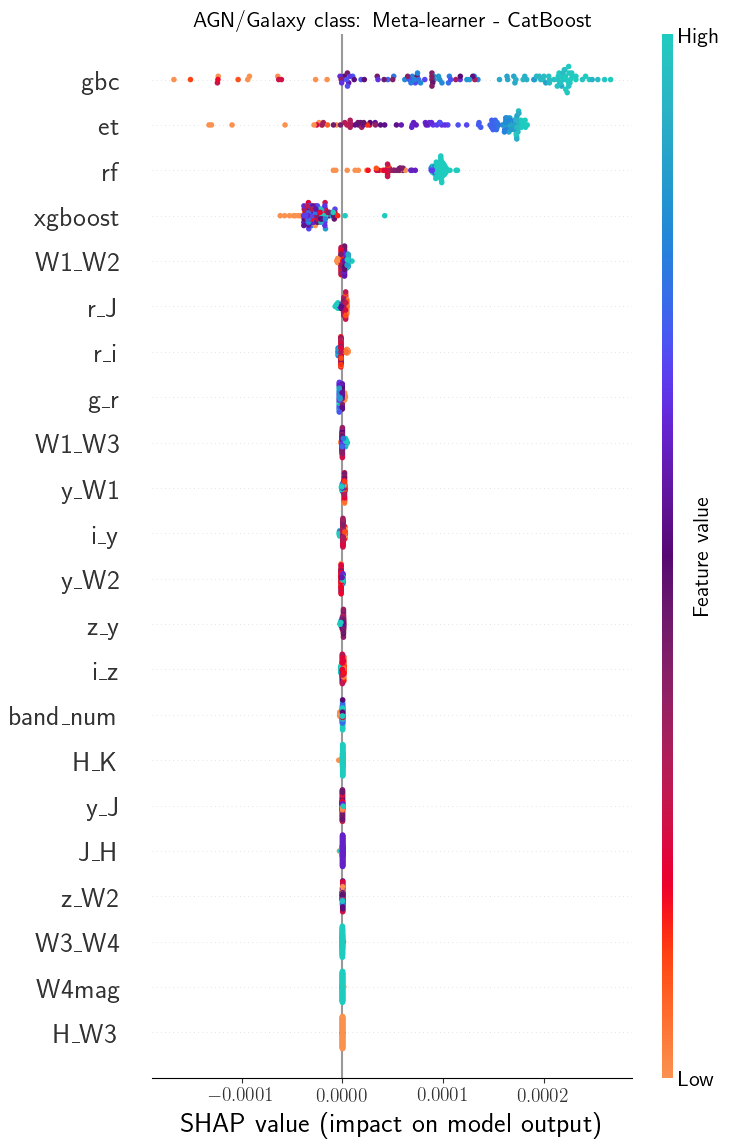

In [35]:
if run_shap_AGN_meta:
    gf.plot_shap_beeswarm('AGN/Galaxy class', model_name_AGN, shap_values_AGN_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_AGN_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [36]:
new_base_logit_AGN = np.log(gv.AGN_thresh / (1 - gv.AGN_thresh))

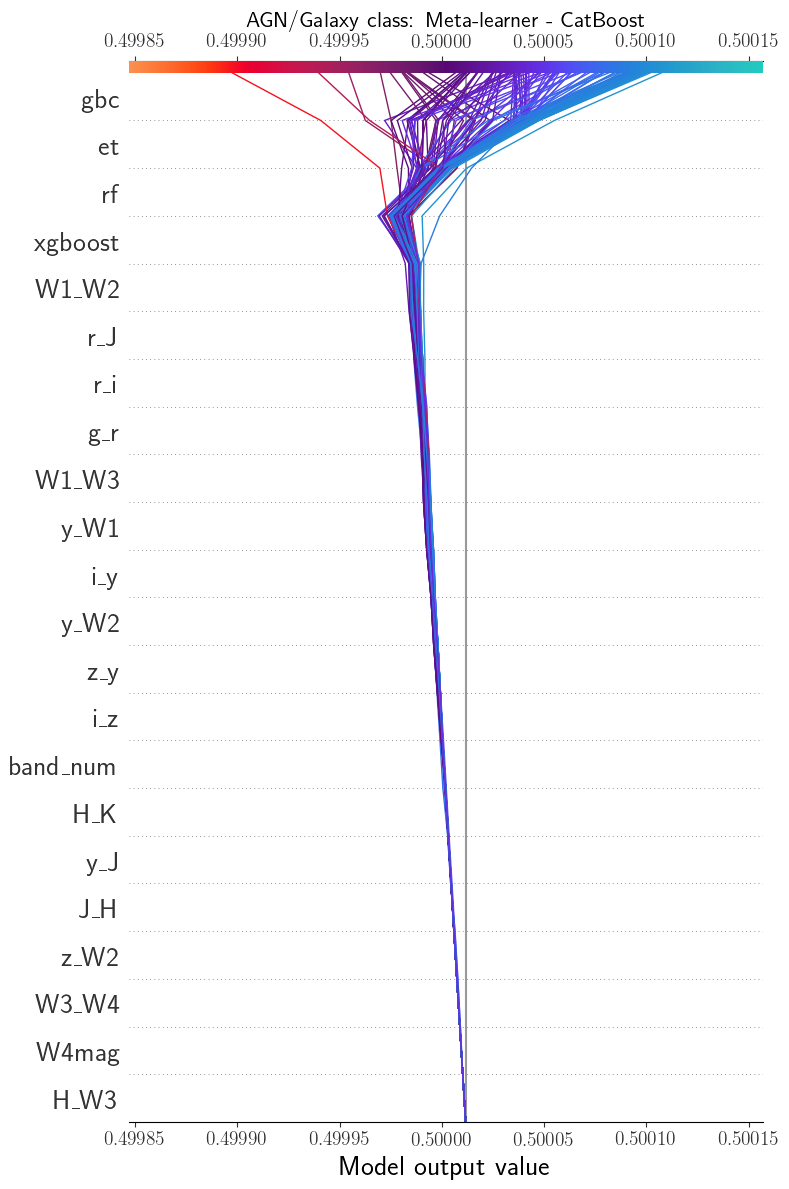

In [87]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.5 - 2.2e-5, 0.5 + 2.1e-5)
if run_shap_AGN_meta:
    xlims_plt       = (full_catalog_df.loc[reduced_data_AGN_df.index, 'Score_AGN'].min() * 0.9999, 
                       full_catalog_df.loc[reduced_data_AGN_df.index, 'Score_AGN'].max() * 1.0001)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side,size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('AGN/Galaxy class', model_name_AGN, shap_values_AGN_meta, explainer_AGN_meta,\
                              reduced_cols_AGN, ax1, 'logit', new_base_value=new_base_logit_AGN, base_meta='Meta', xlim=xlims_plt)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_AGN_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [38]:
if run_shap_AGN_meta:
    sorted_mean_abs_SHAP_AGN = gf.mean_abs_SHAP_meta_model(shap_values_AGN_meta)
    sorted_mean_abs_SHAP_AGN.loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_AGN.loc[:, 'Mean_abs_SHAP'] /\
                                                       sorted_mean_abs_SHAP_AGN.loc[:, 'Mean_abs_SHAP'].sum() * 100
    sorted_mean_abs_SHAP_AGN.to_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_AGN_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')
    sorted_mean_abs_SHAP_AGN = sorted_mean_abs_SHAP_AGN.sort_values(by=['Mean_abs_SHAP'], ascending=False)
    sorted_mean_abs_SHAP_AGN['Cumulative_sum'] = sorted_mean_abs_SHAP_AGN.loc[:, 'Mean_abs_SHAP'].cumsum()

In [39]:
if run_shap_AGN_meta:
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_AGN)

Mean absolute SHAP values scaled to sum 100


,Feature,Mean_abs_SHAP,Cumulative_sum
0,gbc,36.250,36.250
1,et,30.034,66.284
2,rf,21.835,88.119
3,xgboost,7.198,95.318
4,W1_W2,0.879,96.197
5,r_J,0.673,96.870
6,r_i,0.663,97.532
7,g_r,0.494,98.026
8,W1_W3,0.354,98.381
9,y_W1,0.353,98.734


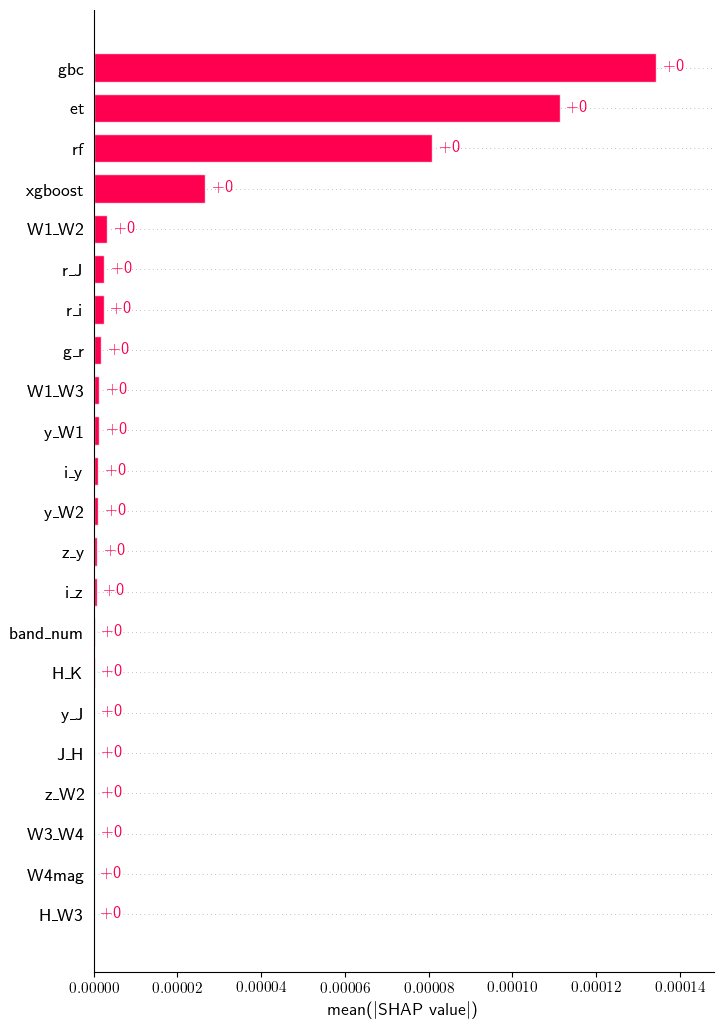

In [40]:
if run_shap_AGN_meta:
    shp_copy_AGN = shap.Explanation(values=shap_values_AGN_meta.values,\
                                    base_values=shap_values_AGN_meta.base_values,\
                                    data=shap_values_AGN_meta.data,\
                                    feature_names=shap_values_AGN_meta.feature_names)
    shap.plots.bar(shap_values=shp_copy_AGN, max_display=len(shp_copy_AGN.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.show()

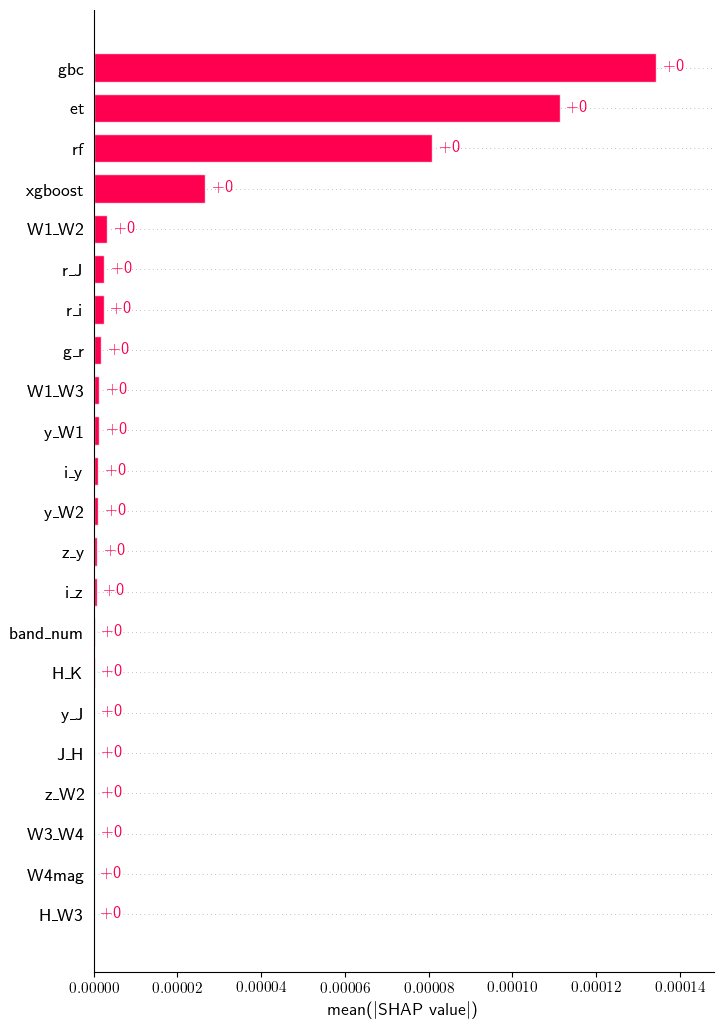

In [41]:
if run_shap_AGN_meta:
    class_AGN    = ['Galaxy' if elem == 0 else 'AGN' for elem in reduced_data_AGN.loc[:, 'class']]
    shap.plots.bar(shap_values=shp_copy_AGN.cohorts(class_AGN).abs.mean(0), max_display=len(shp_copy_AGN.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.show()

In [42]:
if run_shap_AGN_meta:
    # The model's raw prediction for the first observation.
    print(AGN_gal_clf.named_steps['trained_model'].final_estimator_.predict(reduced_data_AGN_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_AGN_meta.expected_value + shap_values_AGN_meta.values[0].sum()).round(5))

1
0.00035


---

#### SHAP - Radio detection model

In [43]:
if run_shap_radio_meta:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [44]:
if run_shap_radio_meta:
    sample_size_radio = 1000
    if not use_high_z_sources:
        if use_zeroth_model:
            filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
        elif not use_zeroth_model:
            filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
        filter_pred_AGN   = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    if use_high_z_sources:
        filter_pred_AGN   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
    sample_size_radio = np.nanmin([sample_size_radio, np.sum(filter_pred_AGN)])
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 121


In [45]:
if run_shap_radio_meta:
    base_models_names_radio = gf.get_base_estimators_names(radio_det_clf)

In [46]:
if run_shap_radio_meta:
    reduced_data_radio    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_radio, random_state=gv.seed).copy()
    display(reduced_data_radio.loc[:, ['LOFAR_detect', 'pred_radio']].describe())
    reduced_data_radio_df = gf.preprocess_data(radio_det_clf, reduced_data_radio, base_models_names_radio)
    reduced_cols_radio    = reduced_data_radio_df.columns

,LOFAR_detect,pred_radio
count,121.000000,121.0
mean,0.239669,0.0
std,0.428657,0.0
min,0.000000,0.0
25%,0.000000,0.0
50%,0.000000,0.0
75%,0.000000,0.0
max,1.000000,0.0


Use FastTreeSHAP package

In [47]:
if run_shap_radio_meta:
    explainer_radio_meta = fasttreeshap.TreeExplainer(radio_det_clf.named_steps['trained_model'].final_estimator_,\
                                                    data=None, feature_perturbation='tree_path_dependent',\
                                                    model_output='raw', feature_dependence='independent',\
                                                    algorithm='auto', n_jobs=12)

In [48]:
if run_shap_radio_meta:
    print('Working with meta-model')
    shap_values_radio_meta = explainer_radio_meta(reduced_data_radio_df)

Working with meta-model


In [49]:
if run_shap_radio_meta:
    print(explainer_radio_meta.expected_value)
    print(np.exp(explainer_radio_meta.expected_value) / (1 + np.exp(explainer_radio_meta.expected_value)))

[-2.65273966]
[0.06582035]


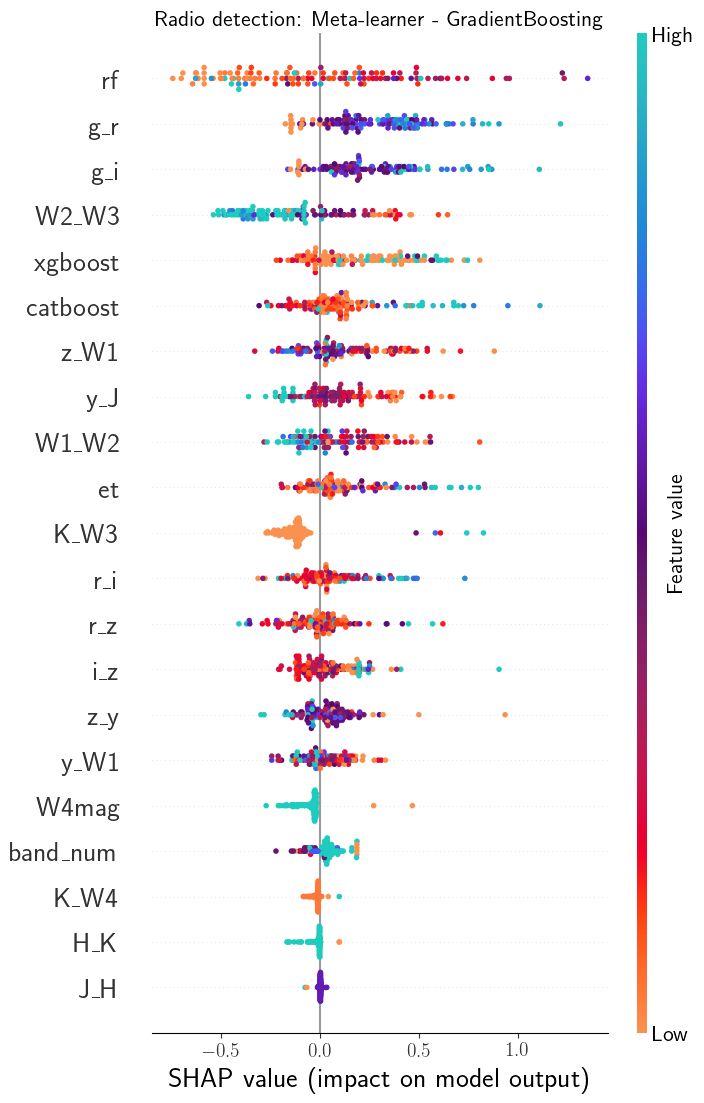

In [50]:
if run_shap_radio_meta:
    gf.plot_shap_beeswarm('Radio detection', model_name_radio, shap_values_radio_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_radio_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [51]:
new_base_logit_radio = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

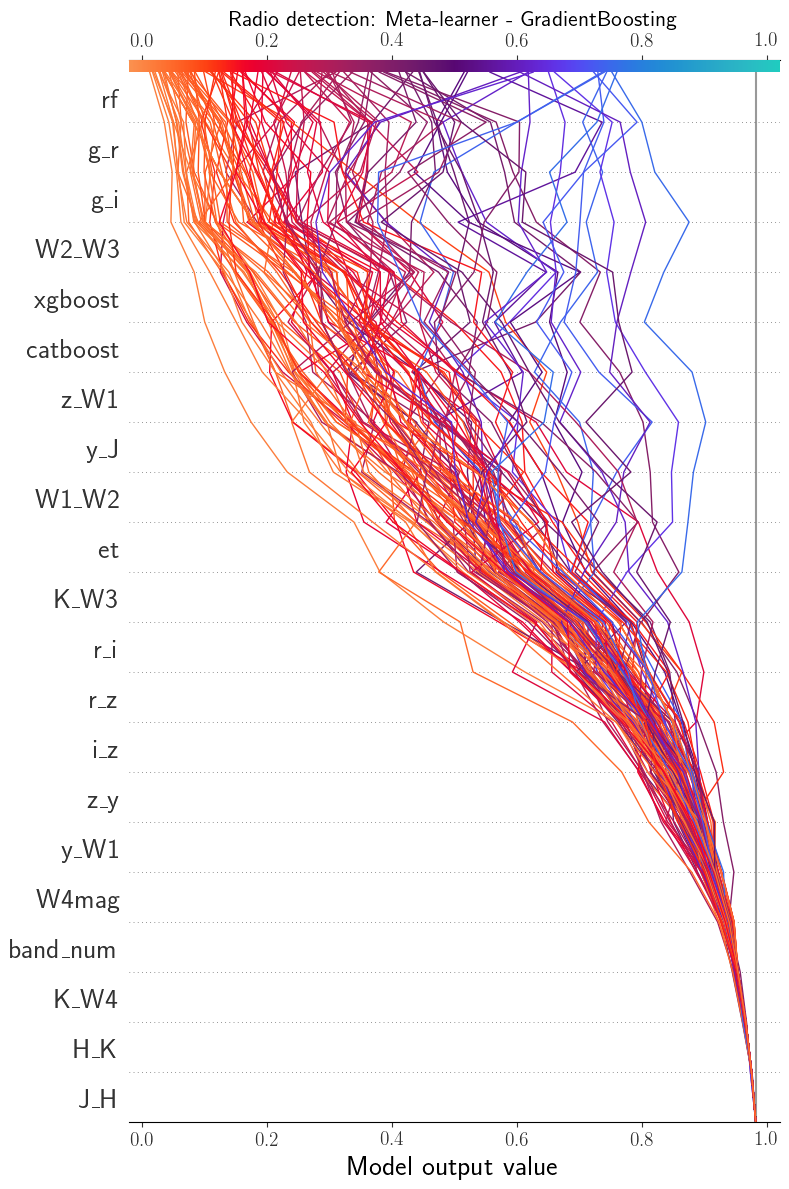

In [88]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_radio_meta:
    xlims_plt       = (full_catalog_df.loc[reduced_data_radio_df.index, 'Score_radio'].min() * 0.99991,\
                       full_catalog_df.loc[reduced_data_radio_df.index, 'Score_radio'].max() * 1.00009)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side,size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('Radio detection', model_name_radio, shap_values_radio_meta, explainer_radio_meta,\
                              reduced_cols_radio, ax1, 'logit', new_base_value=new_base_logit_radio, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_radio_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [53]:
if run_shap_radio_meta:
    sorted_mean_abs_SHAP_radio = gf.mean_abs_SHAP_meta_model(shap_values_radio_meta)
    sorted_mean_abs_SHAP_radio.loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_radio.loc[:, 'Mean_abs_SHAP'] /\
                                                         sorted_mean_abs_SHAP_radio.loc[:, 'Mean_abs_SHAP'].sum() * 100
    sorted_mean_abs_SHAP_radio.to_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_radio_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')
    sorted_mean_abs_SHAP_radio = sorted_mean_abs_SHAP_radio.sort_values(by=['Mean_abs_SHAP'], ascending=False)
    sorted_mean_abs_SHAP_radio['Cumulative_sum'] = sorted_mean_abs_SHAP_radio.loc[:, 'Mean_abs_SHAP'].cumsum()

In [54]:
if run_shap_radio_meta:
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_radio)

Mean absolute SHAP values scaled to sum 100


,Feature,Mean_abs_SHAP,Cumulative_sum
0,rf,11.423,11.423
1,g_r,9.870,21.293
2,g_i,8.721,30.015
3,W2_W3,7.972,37.986
4,xgboost,7.741,45.728
5,catboost,5.696,51.423
6,z_W1,5.580,57.004
7,y_J,5.460,62.464
8,W1_W2,5.450,67.913
9,et,5.115,73.028


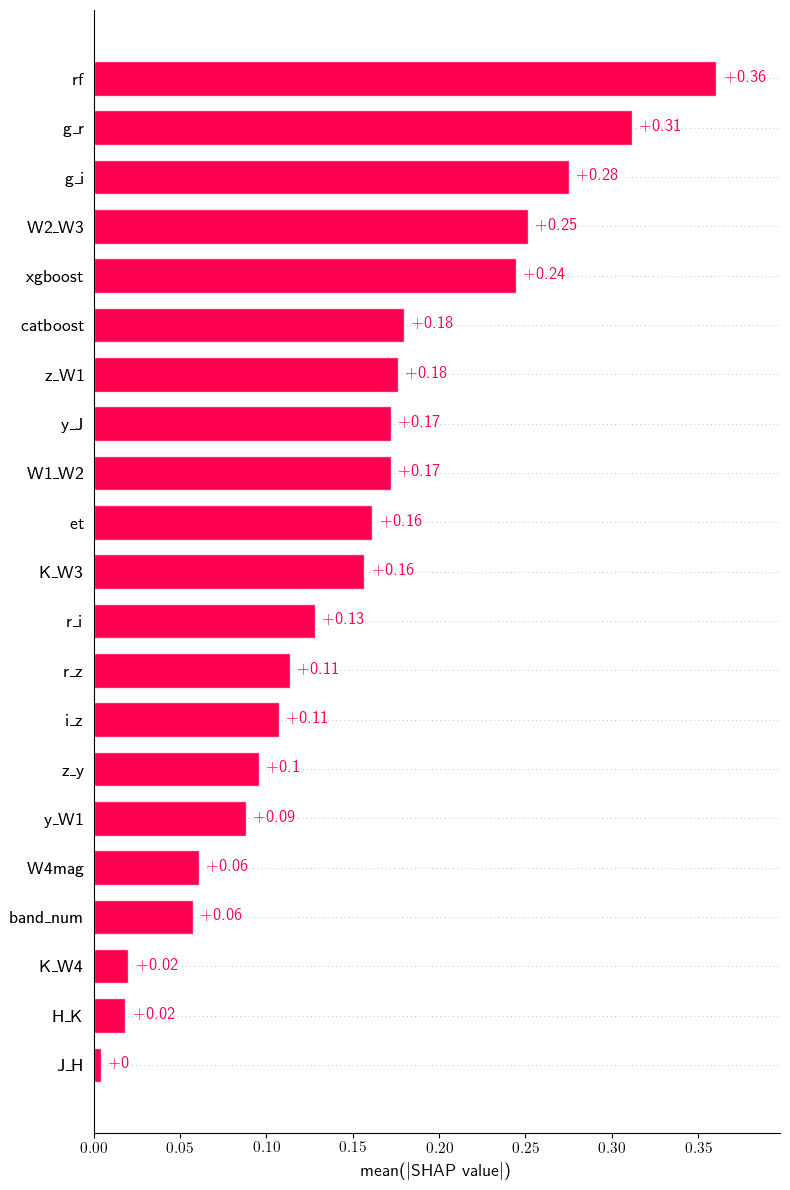

In [55]:
if run_shap_radio_meta:
    shp_copy_radio = shap.Explanation(values=shap_values_radio_meta.values,\
                                    base_values=shap_values_radio_meta.base_values,\
                                    data=shap_values_radio_meta.data,\
                                    feature_names=shap_values_radio_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_radio, max_display=len(shp_copy_radio.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.tight_layout()
    plt.show()

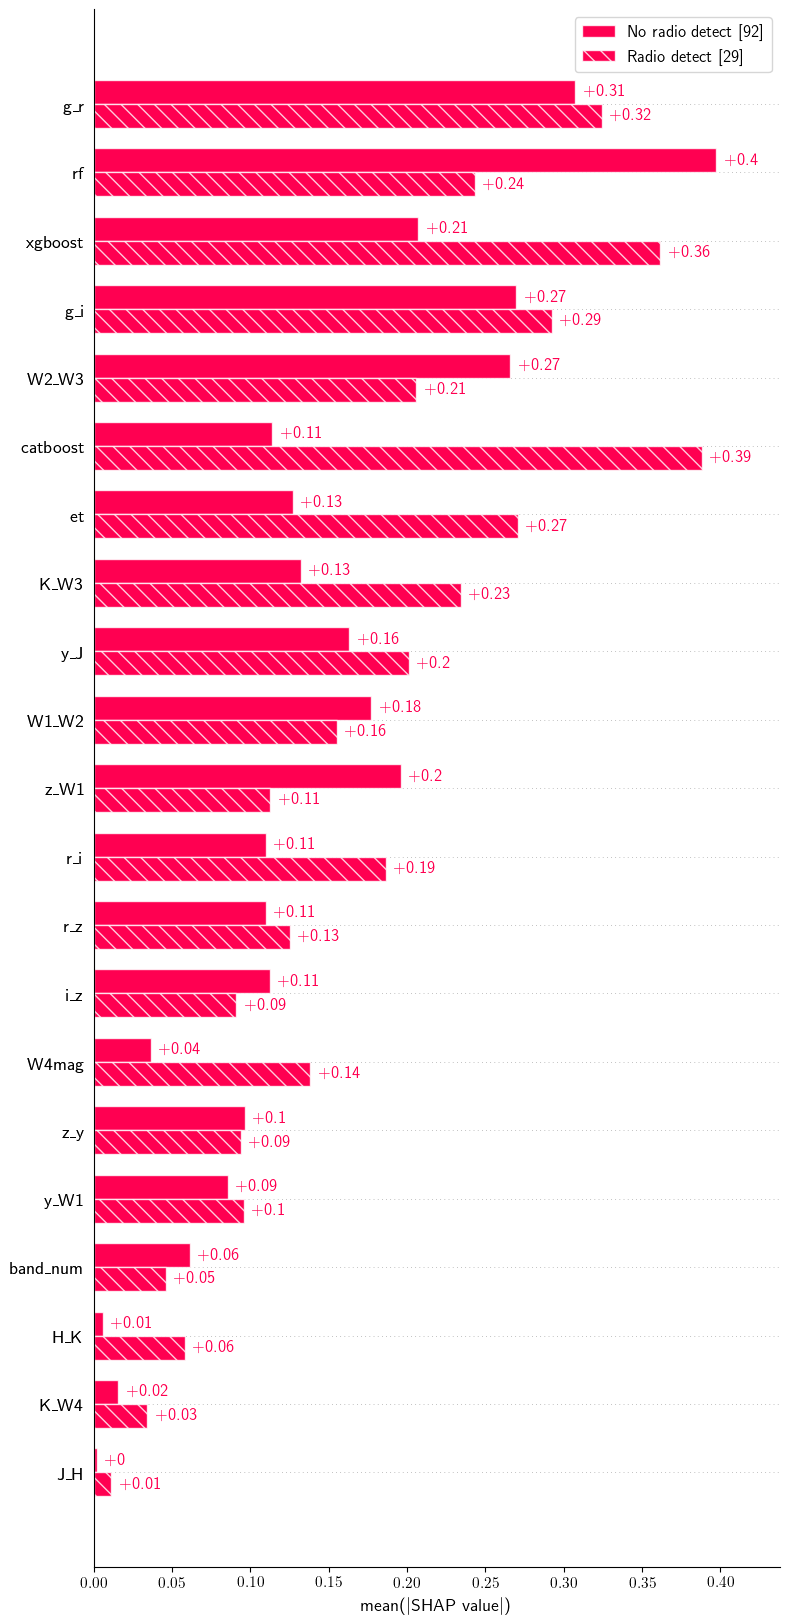

In [56]:
if run_shap_AGN_meta:
    radio_labels  = ['No radio detect' if elem == 0 else 'Radio detect' for elem in reduced_data_radio.loc[:, 'LOFAR_detect']]
    shap.plots.bar(shap_values=shp_copy_radio.cohorts(radio_labels).abs.mean(0), max_display=len(shp_copy_radio.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.tight_layout()
    plt.show()

In [57]:
if run_shap_radio_meta:
    # The model's raw prediction for the first observation.
    print(radio_det_clf.named_steps['trained_model'].final_estimator_.predict(reduced_data_radio_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_radio_meta.expected_value + shap_values_radio_meta.values[0].sum()).round(5))

0
[-1.43649]


---

#### SHAP - First redshift prediction model

In [58]:
if run_shap_z_meta:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [59]:
if run_shap_z_meta:
    sample_size_z    = 1000
    if not use_high_z_sources:
        filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    if use_high_z_sources:
        filter_pred_rAGN   = np.ones_like(full_catalog_df.loc[:, 'pred_radio_AGN']).astype(bool)
    sample_size_z    = np.nanmin([sample_size_z, np.sum(filter_pred_rAGN)])
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 121


In [60]:
if run_shap_z_meta:
    base_models_names_z = gf.get_base_estimators_names(redshift_reg)

In [61]:
if run_shap_z_meta:
    reduced_data_z    = full_catalog_df.loc[filter_pred_rAGN].sample(n=sample_size_z, random_state=gv.seed).copy()
    display(reduced_data_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_z_df = gf.preprocess_data(redshift_reg, reduced_data_z, base_models_names_z)
    reduced_cols_z    = reduced_data_z_df.columns

,Z,pred_Z
count,121.000000,121.000000
mean,4.456719,3.529207
std,0.510382,0.833137
min,4.000000,0.584000
25%,4.115000,3.220000
50%,4.289000,3.797000
75%,4.623000,4.080000
max,6.580000,4.796000


Use FastTreeSHAP package

In [62]:
if run_shap_z_meta:
    explainer_z_meta = fasttreeshap.TreeExplainer(redshift_reg.named_steps['trained_model'].final_estimator_,\
                                                  data=None, feature_perturbation='tree_path_dependent',\
                                                  model_output='raw', feature_dependence='independent',\
                                                  algorithm='auto', n_jobs=12)

In [63]:
if run_shap_z_meta:
    print('Working with meta-model')
    shap_values_z_meta = explainer_z_meta(reduced_data_z_df)

Working with meta-model


In [64]:
if run_shap_z_meta:
    print(explainer_z_meta.expected_value)

[1.32332144]


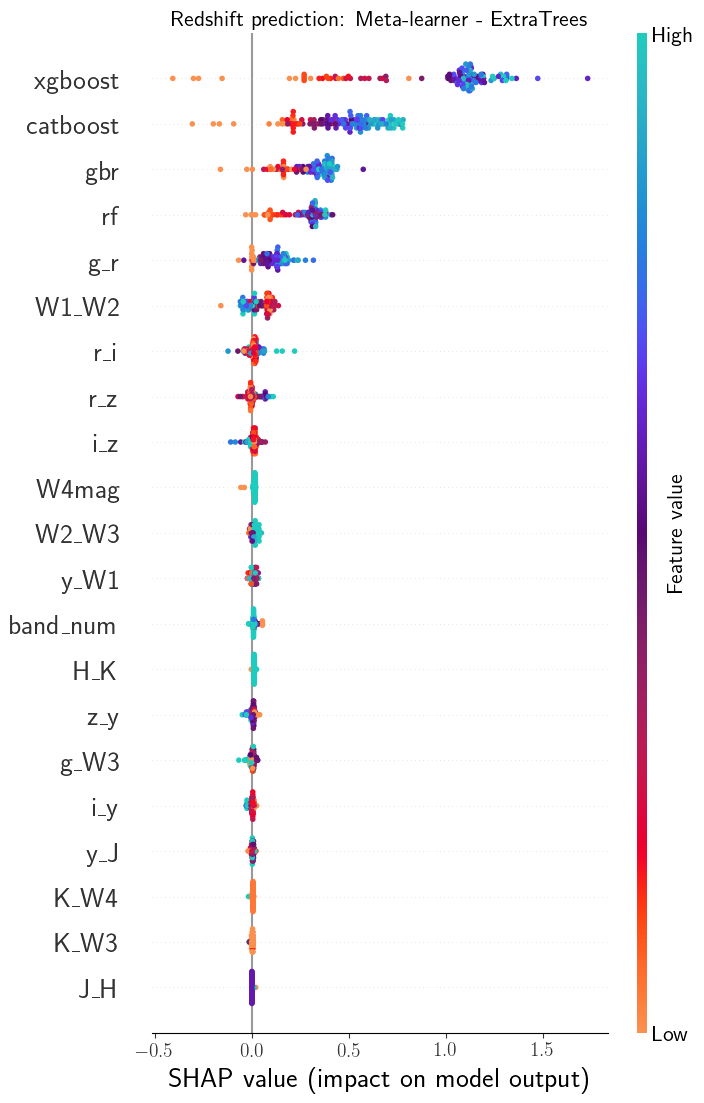

In [65]:
if run_shap_z_meta:
    gf.plot_shap_beeswarm('Redshift prediction', model_name_z, shap_values_z_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_z_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

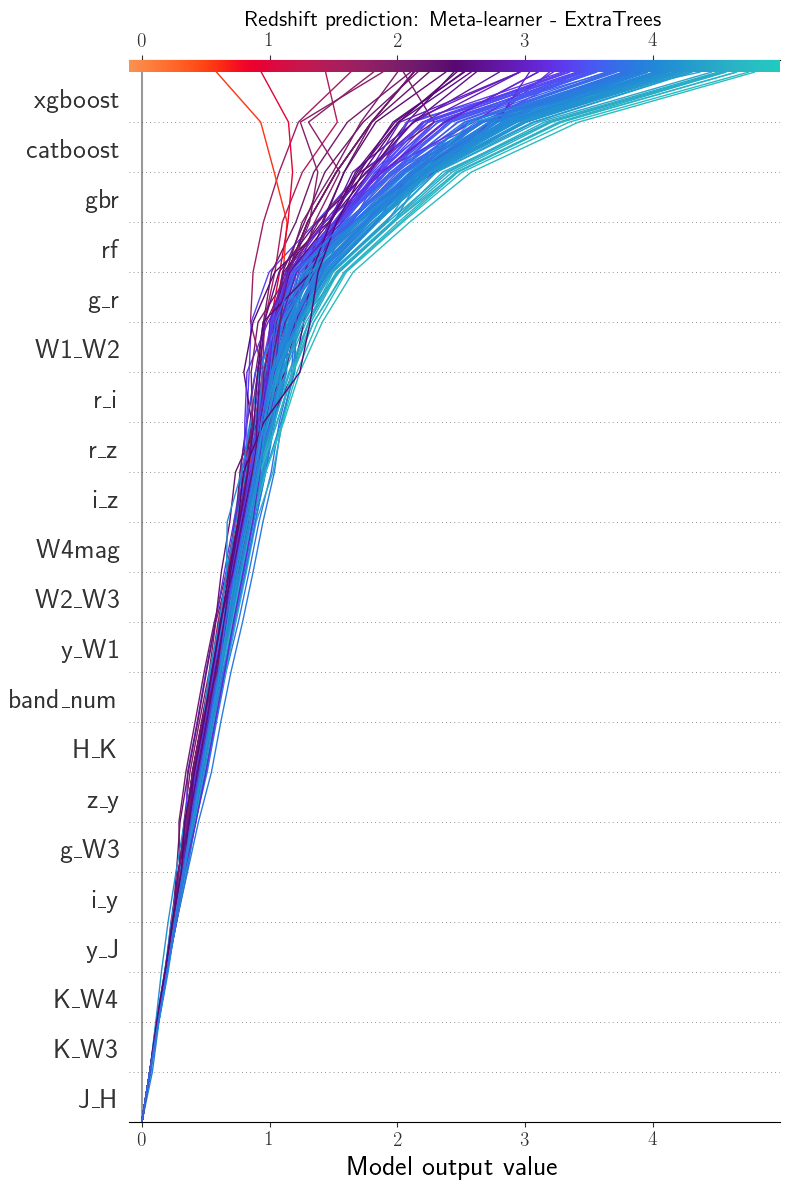

In [66]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_z_meta:
    xlims_plt_z     = (-0.1,\
                       full_catalog_df.loc[reduced_data_z_df.index, 'pred_Z'].max() + 0.2)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side, size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('Redshift prediction', model_name_z, shap_values_z_meta, explainer_z_meta,\
                              reduced_cols_z, ax1, 'identity', new_base_value=0.0, base_meta='Meta', xlim=xlims_plt_z)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_z_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [67]:
if run_shap_z_meta:
    sorted_mean_abs_SHAP_z = gf.mean_abs_SHAP_meta_model(shap_values_z_meta)
    sorted_mean_abs_SHAP_z.loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_z.loc[:, 'Mean_abs_SHAP'] /\
                                                     sorted_mean_abs_SHAP_z.loc[:, 'Mean_abs_SHAP'].sum() * 100
    sorted_mean_abs_SHAP_z.to_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_z_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')
    sorted_mean_abs_SHAP_z = sorted_mean_abs_SHAP_z.sort_values(by=['Mean_abs_SHAP'], ascending=False)
    sorted_mean_abs_SHAP_z['Cumulative_sum'] = sorted_mean_abs_SHAP_z.loc[:, 'Mean_abs_SHAP'].cumsum()

In [68]:
if run_shap_z_meta:
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_z)

Mean absolute SHAP values scaled to sum 100


,Feature,Mean_abs_SHAP,Cumulative_sum
0,xgboost,41.191,41.191
1,catboost,20.297,61.488
2,gbr,13.106,74.595
3,rf,11.648,86.243
4,g_r,4.611,90.853
5,W1_W2,2.400,93.253
6,r_i,1.061,94.314
7,r_z,0.815,95.129
8,i_z,0.745,95.874
9,W4mag,0.580,96.455


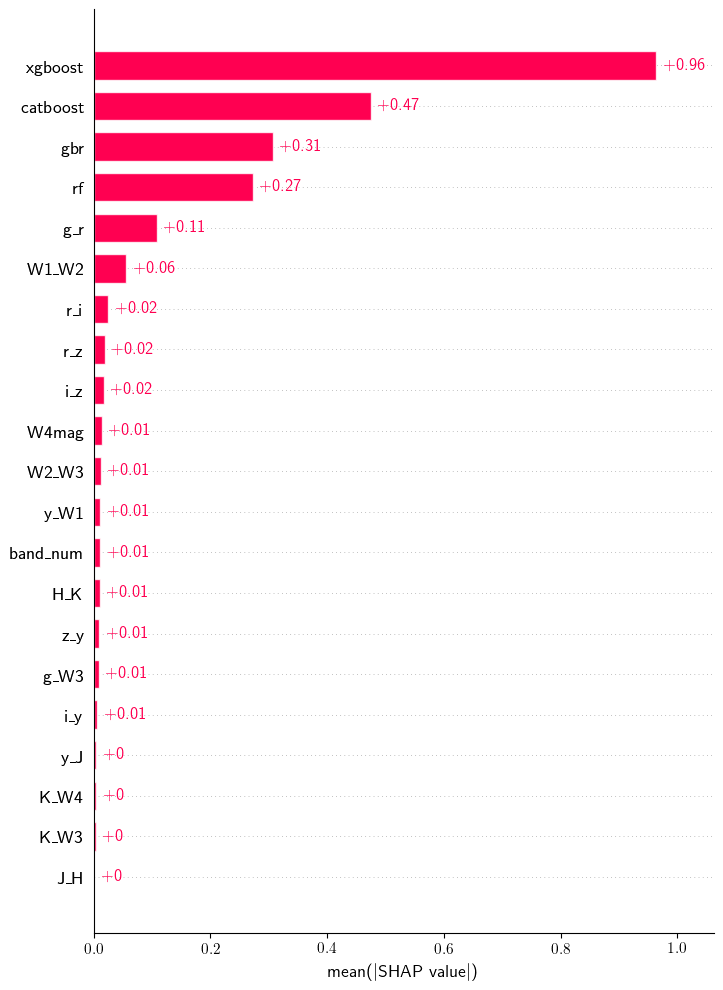

In [69]:
if run_shap_z_meta:
    shp_copy_z = shap.Explanation(values=shap_values_z_meta.values,\
                                    base_values=shap_values_z_meta.base_values,\
                                    data=shap_values_z_meta.data,\
                                    feature_names=shap_values_z_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_z, max_display=len(shp_copy_z.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.show()

In [70]:
if run_shap_z_meta:
    # The model's raw prediction for the first observation.
    print(redshift_reg.named_steps['trained_model'].final_estimator_.predict(reduced_data_z_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_z_meta.expected_value + shap_values_z_meta.values[0].sum()).round(5))

4.26796
[4.26796]


---

#### SHAP - Second redshift prediction model

In [71]:
if not use_second_z_model: run_shap_high_z_meta = False

In [72]:
if run_shap_high_z_meta & use_second_z_model:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [73]:
if run_shap_high_z_meta & use_second_z_model:
    sample_size_high_z      = 1000
    if not use_high_z_sources:
        filter_pred_rAGN_high_z = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                  np.array(full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol))
    if use_high_z_sources:
        filter_pred_rAGN_high_z = np.ones_like(full_catalog_df.loc[:, 'pred_Z']).astype(bool)
    sample_size_high_z      = np.nanmin([sample_size_high_z, np.sum(filter_pred_rAGN_high_z)])
    print(f'Number of selected elements: {sample_size_high_z:,}')

In [74]:
if run_shap_high_z_meta & use_second_z_model:
    base_models_names_high_z = gf.get_base_estimators_names(redshift_reg_2)

In [75]:
if run_shap_high_z_meta & use_second_z_model:
    reduced_data_high_z    = full_catalog_df.loc[filter_pred_rAGN_high_z].sample(n=sample_size_high_z, random_state=gv.seed).copy()
    display(reduced_data_high_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_high_z_df = gf.preprocess_data(redshift_reg_2, reduced_data_high_z, base_models_names_high_z)
    reduced_cols_high_z    = reduced_data_high_z_df.columns

Use FastTreeSHAP package

In [76]:
if run_shap_high_z_meta & use_second_z_model:
    explainer_high_z_meta = fasttreeshap.TreeExplainer(redshift_reg_2.named_steps['trained_model'].final_estimator_,\
                                                       data=None, feature_perturbation='tree_path_dependent',\
                                                       model_output='raw', feature_dependence='independent',\
                                                       algorithm='auto', n_jobs=12)

In [77]:
if run_shap_high_z_meta & use_second_z_model:
    print('Working with meta-model')
    shap_values_high_z_meta = explainer_high_z_meta(reduced_data_high_z_df)

In [78]:
if run_shap_high_z_meta & use_second_z_model:
    print(explainer_high_z_meta.expected_value)

In [79]:
if run_shap_high_z_meta & use_second_z_model:
    gf.plot_shap_beeswarm('High redshift prediction', model_name_high_z, shap_values_high_z_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_high_z_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [80]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_high_z_meta & use_second_z_model:
    xlims_plt_hz    = (gv.high_z_limit - 0.1,\
                       full_catalog_df.loc[reduced_data_high_z_df.index, 'pred_Z'].max() + 0.1)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side, size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('High redshift prediction', model_name_high_z, shap_values_high_z_meta, explainer_high_z_meta,\
                              reduced_cols_high_z, ax1, 'identity', new_base_value=gv.high_z_limit, base_meta='Meta', xlim=xlims_plt_hz)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_high_z_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [81]:
if run_shap_high_z_meta & use_second_z_model:
    sorted_mean_abs_SHAP_high_z = gf.mean_abs_SHAP_meta_model(shap_values_high_z_meta)
    sorted_mean_abs_SHAP_high_z.loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_high_z.loc[:, 'Mean_abs_SHAP'] /\
                                                          sorted_mean_abs_SHAP_high_z.loc[:, 'Mean_abs_SHAP'].sum() * 100
    sorted_mean_abs_SHAP_high_z.to_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_high_z_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')
    sorted_mean_abs_SHAP_high_z = sorted_mean_abs_SHAP_high_z.sort_values(by=['Mean_abs_SHAP'], ascending=False)
    sorted_mean_abs_SHAP_high_z['Cumulative_sum'] = sorted_mean_abs_SHAP_high_z.loc[:, 'Mean_abs_SHAP'].cumsum()

In [82]:
if run_shap_high_z_meta & use_second_z_model:
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_high_z)

In [83]:
if run_shap_high_z_meta & use_second_z_model:
    shp_copy_high_z = shap.Explanation(values=shap_values_high_z_meta.values,\
                                    base_values=shap_values_high_z_meta.base_values,\
                                    data=shap_values_high_z_meta.data,\
                                    feature_names=shap_values_high_z_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_high_z, max_display=len(shp_copy_high_z.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.show()

In [84]:
if run_shap_high_z_meta & use_second_z_model:
    # The model's raw prediction for the first observation.
    print(redshift_reg_2.named_steps['trained_model'].final_estimator_.predict(reduced_data_high_z_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_high_z_meta.expected_value + shap_values_high_z_meta.values[0].sum()).round(5))